In [36]:
import emcee
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
from lmfit import Parameters, Parameter, minimize
from astropy.utils.console import ProgressBar
from astropy.modeling import models
import string,re,sys
import types
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [51]:
def up_lims(p,XC,RC,XX,RR):
    F_xc_log=np.log(XX/XC)
    F_rc_log=np.exp(np.tan(p[1]))+np.tan(p[0])*(F_xc_log)
    return(F_rc_log)
def lrlx_prior(p,d_est,flag,XC,RC):
    theta,b,dist = p[0],p[1],p[2]
    if theta < 0.0:
        return(-np.inf)
    if dist < 0.0:
        return(-np.inf)
    #if you have upper limit constraints put them here 
    if flag=='y':
        LX=8e34
        LR=7.8e27
        F_rc_log=up_lims([p[0],p[1],p[2]],XC,RC,LX,LR)
        if np.exp(F_rc_log)*RC>LR:
            return -np.inf
    prior = 0.0
    #known distance distribution
    prior = ss.norm.logpdf(dist,scale=d_est[1],loc=d_est[0])
    #no need to set priors on theta,b, the default uniform is fine
    if np.isnan(prior):
        return(-np.inf)
    return(prior)
def lumin(flux,dist,flag,unit='',freq=1.):
    if flag=='X':
        return(flux*4.*np.pi*(dist*1e3*3.08e18)**2)
    elif flag=='R':
        return(flux*unit*(freq*1e9)*4.*np.pi*(dist*1e3*3.08e18)**2)
def lp(p,X_flux,R_flux,X_err_low,X_err_high,R_err,freq,d_est,XC,RC,radu,flag):
    theta,b,dist = p[0], p[1], p[2]
    if radu=='u':
        sc=1e-29
    elif radu=='m':
        sc=1e-26
    elif radu=='':
        sc=1e-23
    else:
        raise ValueError('Radio unit must be u,m or '' for uJy,mJy, or Jy')
    #convert fluxes to luminosities
    y_lin=lumin(R_flux,dist,'R',sc,freq)
    y_err_lin=lumin(R_err,dist,'R',sc,freq)
    x_lin=lumin(X_flux,dist,'X')
    x_errl_lin=lumin(X_err_low,dist,'X')
    x_erru_lin=lumin(X_err_high,dist,'X')
    x =np.log(x_lin/XC)
    y =np.log(y_lin/RC)
    x_err =(((x_errl_lin+x_erru_lin)/2.)/(x_lin))
    y_err =((y_err_lin)/(y_lin))
    #theta parametrization as both X and Y have errors
    Delta = (np.cos(theta)*y - np.sin(theta)*x-b*np.cos(theta))**2
    Sigma = (np.sin(theta))**2*x_err**2+(np.cos(theta))**2*y_err**2
    lp = -0.5*np.nansum(Delta/Sigma)-0.5*np.nansum(np.log(Sigma))
    prior = lrlx_prior(p,d_est,flag,XC,RC)
    return(lp+prior)
def summary(x):
    median=np.percentile(x,50)
    pct15=np.percentile(x,15)
    pct85=np.percentile(x,85)
    return(median,median-pct15,pct85-median)
def power(X,amp,XC,index):
    f=models.PowerLaw1D(amp,XC,-1.*index)
    return(f(X))
def errf(par,x,y):
    ampl=par['amp'].value
    ind=par['index'].value
    fitf = ampl + ind * x
    return (y-fitf)

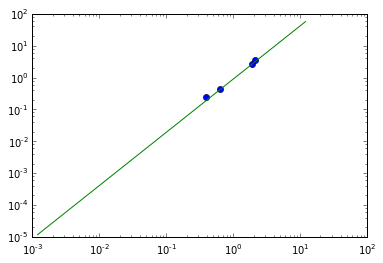

In [67]:
#read in data file...
#data=np.loadtxt(filename)

#generate test data
dist=[5.9,0.5]#in kpc
rf=5.#radio nu in ghz
ru=1e-29#Jy multiplier for radio unit
radu='u'#radio unit

vals=np.logspace(34,38,100)
f_x=np.array([  8.02200284e-10  , 1.27776441e-09 ,  3.87811454e-09 ,  4.18887727e-09])
f_r=np.array([  23.2 ,  40. ,  245.3 , 340. ])
f_r_err=np.array([ 5.,   4. ,  5. ,  7.8])
f_x_errl=np.array([  5.20662071e-11 ,  8.85715877e-11 ,  1.14258418e-10 ,  1.88033698e-10])
f_x_erru=np.array([  5.27202279e-11  , 8.62887218e-11 ,  1.05411335e-10 ,  1.77644297e-10])

l_x=lumin(f_x,dist[0],'X')
XC=ss.gmean(l_x)
l_r=lumin(f_r,dist[0],'R',ru,rf)
RC=ss.gmean(l_r)


fig=plt.figure()
plt.errorbar(l_x/XC,l_r/RC,yerr=f_r_err/RC,xerr=[f_x_errl/XC,f_x_erru/XC],ls='',marker='o')
plt.plot(vals/XC,power(vals,0.9,XC,1.67))
#plt.errorbar(2e36/XC,1e28/RC,lolims=True,marker='o')
plt.yscale('log')
plt.xscale('log')


In [56]:
ndim=3
print 'number of dimensions is ',ndim
nWalkers = ndim*10


#least squares walker initalization
x =np.log(l_x/XC)
y =np.log(l_r/RC)
y_err =(lumin(f_r,dist[0],'R',ru,rf)/(l_r))
x_err =(lumin(f_x_errl,dist[0],'X')/(l_x))
par=Parameters()
par.add('amp', value=0.005, vary=True)
par.add('index', value=1.0, vary=True)
amp_ls=[]
ind_ls=[]
l_r_s=[]
l_x_s=[]
nsim=100
samp_r=np.random.normal(0,1,nsim)
samp_x=np.random.normal(0,1,nsim)
for i in range(0,nsim):
    for j in range(0,len(x)):
        l_r_s.append((samp_r[i]*y_err[j])+y[j])
        l_x_s.append((samp_x[i]*x_err[j])+x[j])
    l_x_sarr=np.array(l_x_s)
    l_r_sarr=np.array(l_r_s)
    resu=minimize(errf,par,args=(l_x_sarr, l_r_sarr),method='leastsq')
    amp_ls.append((resu.params['amp'].value))
    ind_ls.append(resu.params['index'].value)
val1,up1,low1=summary(amp_ls)
val2,up2,low2=summary(ind_ls)
print val1,val2

p0 = np.zeros((nWalkers,ndim))
p0[:,0] = np.random.randn(nWalkers)*(low2+up2)+(val2-low2)
p0[:,1] = np.random.randn(nWalkers)*(low1+up1)+(val1-low1)
p0[:,2] = ((np.random.randn(nWalkers))*0.01)+dist[0]
'''p0 = np.zeros((nWalkers,ndim))
for i in np.arange(ndim):
    p0[:,i]=(((np.random.randn(nWalkers))*0.01)+guess[i])'''
        
sampler = emcee.EnsembleSampler(nWalkers, ndim, lp, args=[f_x,f_r,f_x_errl,f_x_erru,f_r_err,\
                                                          rf,dist,XC,RC,radu,'n'],threads=1)


number of dimensions is  3
-0.107044629458 1.61313363537


In [57]:
pp=[val2,val1,dist[0]]
lp(pp,f_x,f_r,f_x_errl,f_x_erru,f_r_err,rf,dist,XC,RC,radu,'n')

-589.64376809466387

In [58]:
nBurn=200
with ProgressBar(nBurn,ipython_widget=True) as bar:
    for i,result in enumerate(sampler.sample(p0,iterations=nBurn)):
        bar.update()
pos,prob,state=result[0],result[1],result[2]

In [63]:
sampler.reset()
nSamp=500
with ProgressBar(nSamp,ipython_widget=True) as bar:
    for i,result in enumerate(sampler.sample(pos,iterations=nSamp)):
        bar.update()
pos,prob,state=result[0],result[1],result[2]

In [64]:
slope_final=summary(np.tan(sampler.flatchain[:,0]))#slope
norm_final=summary(np.tan(sampler.flatchain[:,1]))#normalization

print 'slope:', slope_final[0],slope_final[1],slope_final[2]
print 'amp:', np.exp(norm_final[0]), norm_final[1]*np.exp(norm_final[0]),norm_final[2]*np.exp(norm_final[0])


slope: 1.66952265812 0.103214747098 0.108871098831
amp: 0.934212616875 0.13715814064 0.123360946174


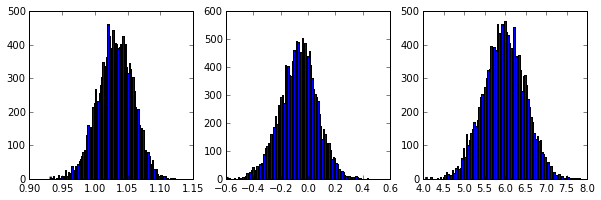

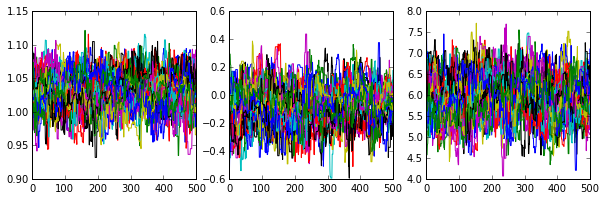

In [65]:
figa = plt.figure(figsize=(10,3))
for i in range(0,ndim):
    plt.subplot(1,3,i+1)
    patches = plt.hist(sampler.flatchain[:,i],bins=100)
figa.subplots_adjust(hspace=.5)


figb = plt.figure(figsize=(10,3))
for i in range(0,ndim):
    plt.subplot(1,3,i+1)
    plt.plot(sampler.chain[:,:,i].T)
figb.subplots_adjust(hspace=.5)

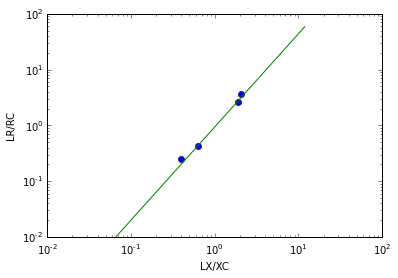

In [68]:
fig=plt.figure()
plt.errorbar(l_x/XC,l_r/RC,xerr=[f_x_errl/XC,f_x_erru/XC],yerr=f_r_err/RC,ls='',marker='o')
plt.plot(vals/XC,power(vals,np.exp(norm_final[0]),XC,slope_final[0]))
plt.yscale('log')
plt.xscale('log')
plt.ylim(0.01,100)
plt.xlim(0.01,100)
plt.xlabel('LX/XC')
plt.ylabel('LR/RC')